<a href="https://colab.research.google.com/github/codemeharder21/MachineLearning/blob/main/DCUNetProject/Tensorflow/DCUNetImageSegmentationTf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'casia-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F59500%2F115146%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240208%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240208T154255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5642fb6129a6db78b813f9d95dd6a6ac404c4914b0b279de575967b70ec7f48789b003c562bb29de407b0c9808dcfd2db1a979d907d4ec2a084f7ae3a0695b6c12f77b5fa8a7e7362854fab6e20df175a673dbaa07b07a643c97fc24590d1a435cecb772bfcf829b41a4c96f9af424f4a7bb5ecad26db98955cd544f0c683803a54ce4771cec0ff9817a0f312cb8ab8ba9c57d608d17e20ca193b29725061955f4861ac104dc1391238dcb4ef6b1255c4c4345336cb78963c7c7f50db2533751adbf29d93dd0ca1e61ee9baa243eb3c4ab94ac6b41b059316d945e4f167fc38119a53ca7e5981fb08d8da8b26d78e7c64b125052fd62db50db30d739756a9ffb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5600476572 bytes downloaded
Downloaded and uncompressed: casia-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
from PIL import Image,ImageChops,ImageEnhance
import cv2

In [4]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def apply_high_pass_filter(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    high_pass_filter = np.array([[-1, -2, -1],
                                 [0, 0, 0],
                                 [1, 2, 1]])
    another_filter=high_pass_filter.T

    edge_image = cv2.filter2D(gray_image, -1, high_pass_filter)
    another_image=cv2.filter2D(gray_image,-1,another_filter)

    edge_image = np.expand_dims(edge_image, axis=-1)
    another_image=np.expand_dims(another_image,axis=-1)

    return edge_image,another_image

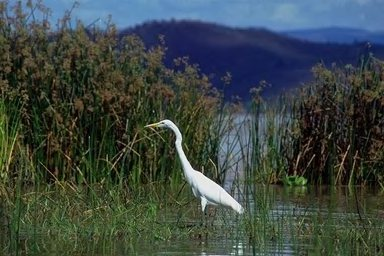

In [6]:
originalImagePath = '/kaggle/input/casia-dataset/CASIA1/Au/Au_ani_0002.jpg'
originalImage=np.asarray(Image.open(originalImagePath))
Image.open(originalImagePath)

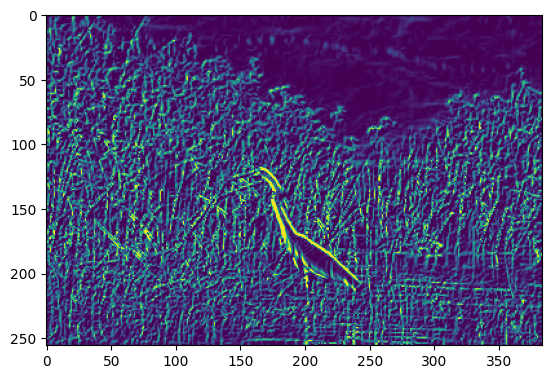

In [7]:
residualImage1,residualImage2=apply_high_pass_filter(np.asarray(Image.open(originalImagePath)))
residualImage=residualImage1+residualImage2
plt.imshow(residualImage)
plt.show()

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def myDataGenerator(batchSize, splicedDir, groundTruthDir):
    splicedDataGenerate = ImageDataGenerator(rescale=1./255)
    groundTruthDataGenerate = ImageDataGenerator(rescale=1./255)

    splicedDataGenerator = splicedDataGenerate.flow_from_directory(
        splicedDir,
        target_size=(256, 384),
        batch_size=batchSize,
        color_mode="rgb",
        class_mode=None,
        shuffle=True
    )

    groundTruthGenerator = groundTruthDataGenerate.flow_from_directory(
        groundTruthDir,
        target_size=(256, 384),
        batch_size=batchSize,
        color_mode="grayscale",
        class_mode=None,
        shuffle=True
    )

    while True:
        splicedImages = splicedDataGenerator.next()
        groundTruthImages = groundTruthGenerator.next()

        yield splicedImages, groundTruthImages


In [ ]:
batch_size = 32
num_epochs = 10

In [9]:
train_gen = myDataGenerator(batch_size, '/kaggle/input/casia2-0groundtruth/CASIA 1.0 groundtruth/Sp', '/kaggle/input/casia2-0groundtruth/CASIA 1.0 groundtruth/CM')

In [10]:
import tensorflow as tf

In [11]:
tempA='sigmoid'

In [12]:
def defineLayers(filters,numberOfLayers):
  x=[]
  for i in range (numberOfLayers):
    x.append(tf.keras.layers.Conv2D(filters,3,activation=tempA))
  x.append(tf.keras.layers.MaxPooling2D())
  return x

In [13]:
def defineResidualImageLayers(filters,numberOfLayers):
  x=[]
  for i in range (numberOfLayers):
    x.append(tf.keras.layers.Conv2D(filters,3,activation=tempA))
  x.append(tf.keras.layers.Conv2D(filters,7,activation=tempA))
  x.append(tf.keras.layers.Conv2D(filters,3,activation=tempA,strides=(2,2)))
  return x

In [14]:
def applyConvolutionResidualImage(input,layers):
  res=input
  ans=input
  # ans=layers[0](input)
  for i in range(0,len(layers)-2):
    ans=layers[i](ans)
  res=layers[i+1](res)
  res=res+ans
  res=layers[i+2](res)
  return res

In [15]:
def applyConvolution(input,layers):
  ans=input
  for i in layers:
    ans=i(ans)
  return ans

In [16]:
def defineUpSampleLayers(filters):
  # currSkipConn=tf.keras.layers.Cropping2D(cropping=cropPattern)
  upLayers=[]
  # ans=tf.keras.layers.Concatenate(input,currSkipConn)
  upLayers.append(tf.keras.layers.Conv2D(filters,3,padding='same',activation=tempA))
  upLayers.append(tf.keras.layers.UpSampling2D())
  return upLayers

In [17]:
def applyUpSampling(upLayers,input,currSkipConn):
  ans=input
  temp=tf.keras.layers.Concatenate()([ans,currSkipConn])
  ans=temp
  for i in upLayers:
    ans=i(ans)
  # print(ans.shape)
  return ans

In [18]:
def cropSkipConnections(skipArr):
  skipArr[3]=tf.keras.layers.Cropping2D(cropping=4,)(skipArr[3])
  skipArr[2]=tf.keras.layers.Cropping2D(cropping=((20,3),(20,3)))(skipArr[2])
  skipArr[1]=tf.keras.layers.Cropping2D(cropping=((50,3),(50,3)))(skipArr[1])
  skipArr[0]=tf.keras.layers.Cropping2D(cropping=(55,55))(skipArr[0])
  return skipArr

In [19]:
#inChannels is a 2D array with (noOfFilters,noOfLayers) for a number of rows
#inResidualChannels is a 2d array with (noOfFilters,noOfLayers) for a number of rows
def dcUNetModel(input,inputResidual,inChannels,inResidualChannels,upSamples):
  convolutionResult=input
  residualConvResult=inputResidual
  skipArray=[]
  for i in inChannels:
    currentConvolution=defineLayers(i[0],i[1])
    convolutionResult=applyConvolution(convolutionResult,currentConvolution)
    skipArray.append(convolutionResult)
  convolutionResult=tf.keras.layers.Conv2D(inChannels[len(inChannels)-1][0],2,activation=tempA)(convolutionResult)
  for i in inResidualChannels:
    currentConvolution=defineResidualImageLayers(i[0],i[1])
    residualConvResult=applyConvolutionResidualImage(residualConvResult,currentConvolution)
  # print(residualConvResult.shape)
  # print(convolutionResult.shape)
  netResult=tf.keras.layers.Concatenate(axis=-1)([convolutionResult,residualConvResult])
  dilationConv=[]
  for i in range (1,4):
    dilationConv.append(tf.keras.layers.Conv2D(256,3,padding='same',dilation_rate=i,activation=tempA)(netResult))
  netResult=tf.keras.layers.Concatenate()([dilationConv[0],dilationConv[1],dilationConv[2]])
  netResult=tf.keras.layers.UpSampling2D()(netResult)
  skipArray=cropSkipConnections(skipArray)
  for i in range(len(upSamples)):
    currentUpSampleLayer=defineUpSampleLayers(upSamples[i])
    netResult=applyUpSampling(currentUpSampleLayer,netResult,skipArray[3-i])
  netResult=tf.keras.layers.Conv2D(64,3,padding="same",activation="sigmoid")(netResult)
  netResult=tf.keras.layers.Conv2D(1,1,activation="sigmoid")(netResult)
  netResult=tf.keras.layers.ZeroPadding2D(padding=112)(netResult)
  model=tf.keras.Model(inputs=(input,inputResidual),outputs=netResult)
  return model

In [20]:
originalInputShape=(256,384,3)
residualInputShape=(256,384,1)
originalInput=tf.keras.Input(shape=originalInputShape)
residualInput=tf.keras.Input(shape=residualInputShape)
inChannels=[[64,2],[128,2],[256,3],[512,3],[512,3]]
inResidualChannels=[[8,3],[16,3],[32,3],[64,3],[128,3]]
upSamples=[512,256,128,64]

In [21]:
model=dcUNetModel(originalInput,residualInput,inChannels,inResidualChannels,upSamples)

In [ ]:
path="/kaggle/input/casia-dataset/CASIA1/Sp/Sp_D_CND_A_pla0005_pla0023_0281.jpg"
Image.open(path)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 384, 1)]        0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 254, 382, 8)          80        ['input_2[0][0]']             
                                                                                                  
 conv2d_15 (Conv2D)          (None, 252, 380, 8)          584       ['conv2d_14[0][0]']           
                                                                                                  
 conv2d_17 (Conv2D)          (None, 250, 378, 8)          400       ['input_2[0][0]']             
                                                                                              

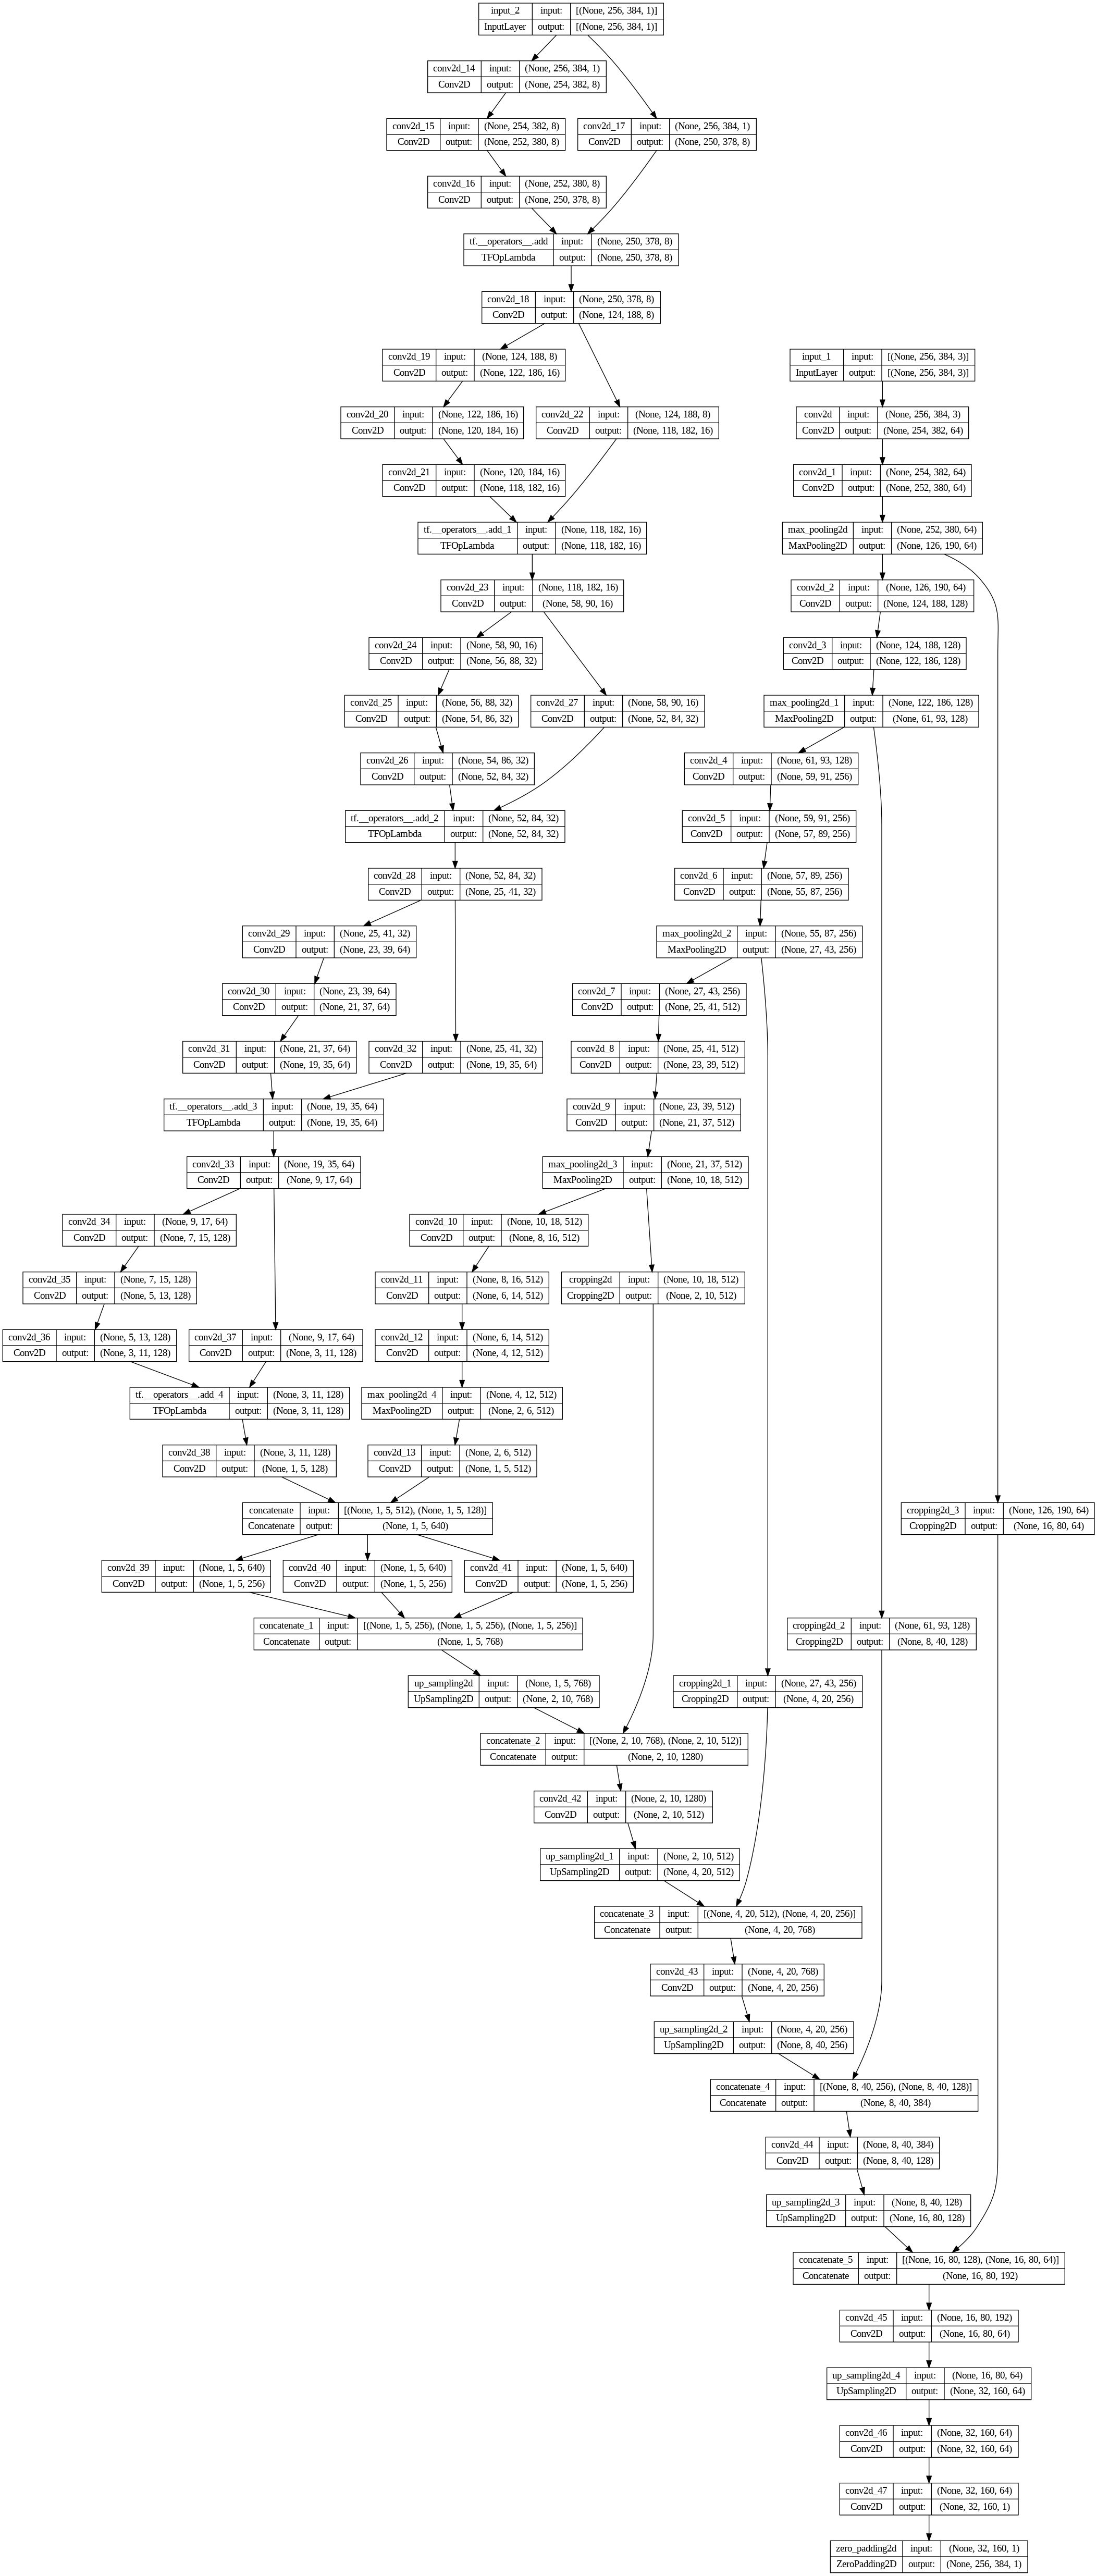

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="binary_crossentropy",metrics=["accuracy"])